In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [20]:
def plot_time_series(time, series, start = 0, end = None, label=None):
    plt.plot(time[start:end], series[start:end], label = label)
    plt.xlabel =  "Time"
    plt.ylabel = "Value"

def trend(time, slope= 0):
    return time * slope

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1/np.exp(3 * season_time))

def seasonality(time, period, amplitude, phase=0):
    season_time = ((time + phase)%period)/period
    return amplitude  * seasonal_pattern(season_time)

def white_noise(time, noise_level = 1, seed = None):
    rnd = np.random.RandomState(seed)   #Returns the Gaussian Value from the given seed
    return rnd.randn(len(time)) * noise_level


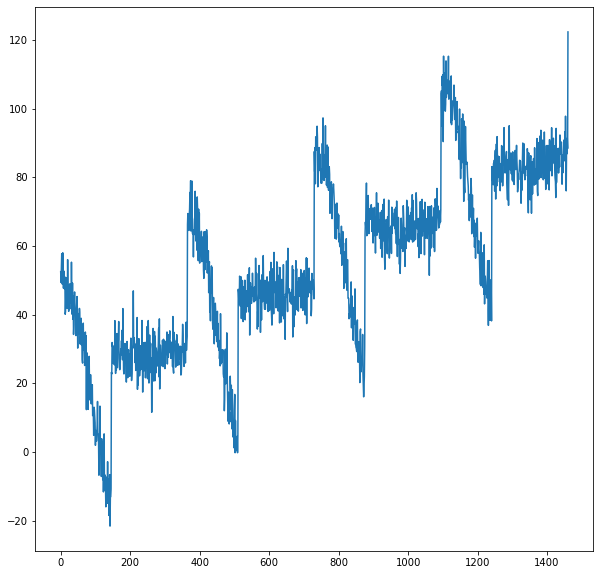

In [21]:
time = np.arange(365*4 +1)

baseline = 10
amplitude = 40
slope = 0.05


noise_level = 5
noise = white_noise(time, noise_level, seed =42)

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude) + noise

plt.figure(figsize=(10,10))
plot_time_series(time, series, label = "Time Series Plot")

# Naive Forcasting

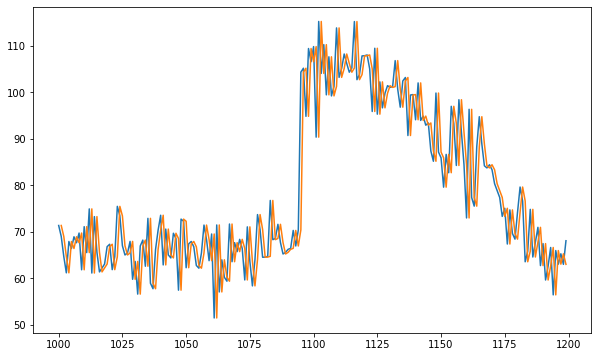

In [23]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

naive_forcast = series[split_time - 1: -1]  #Means That it will start from 999 to the first one

plt.figure(figsize=(10,6))
plot_time_series(time_valid, x_valid, start=0, end=200, label = "Series")
plot_time_series(time_valid, naive_forcast, start=1, end=200, label = "Forcast")
plt.show()

Now let's compute the mean absolute error between the forecasts and the predictions in the validation period:

In [31]:
error = tf.keras.metrics.mae(x_valid, naive_forcast)
print("The MAE is: ", error)
print("The MAE is: ", error.numpy())

The MAE is:  tf.Tensor(5.937908515321672, shape=(), dtype=float64)
The MAE is:  5.937908515321672


In [38]:
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values.If window_size=1, then this is equivalent to naive forecast"""
    forecast = []
    for i in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forcast)

In [61]:
#another method for moving average (both gives same output)
def moving_average_forecast2(series, window_size):
    """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast
     This implementation is *much* faster than the previous one"""
    mov = np.cumsum(series)
    mov[window_size:] = mov[window_size:] - mov[:-window_size]
    return mov[window_size - 1:-1] / window_size

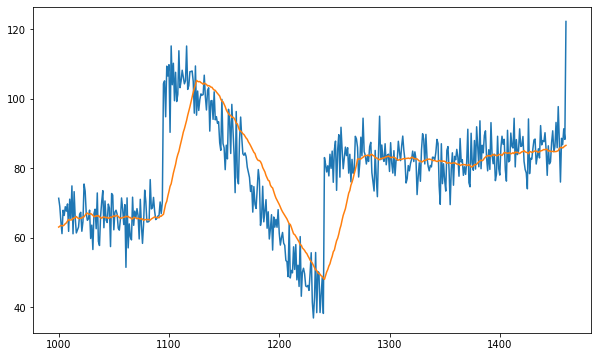

In [62]:
moving_avg = moving_average_forecast(series, window_size=30)[split_time -30:] #Moving Avg 30 Days
#If You donot split the moving avg it will give an error saying that shapes are different with difference of 30
plt.figure(figsize=(10,6))
plot_time_series(time_valid, x_valid, label = "Series")
plot_time_series(time_valid, moving_avg, label = "Moving Avg 30 Days")

In [64]:
error2 = tf.keras.metrics.mean_absolute_error(x_valid, moving_avg)
error2

<tf.Tensor: shape=(), dtype=float64, numpy=7.142418570620783>

That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is 365 days, we will subtract the value at time t – 365 from the value at time t.

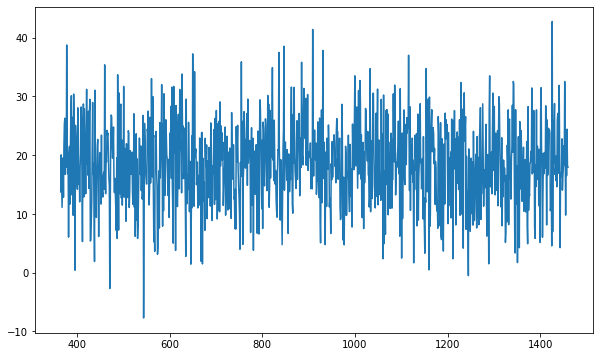

In [66]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10,6))
plot_time_series(diff_time,diff_series, label="Series(t) - Series(t-365)")

Focusing on the validation period:

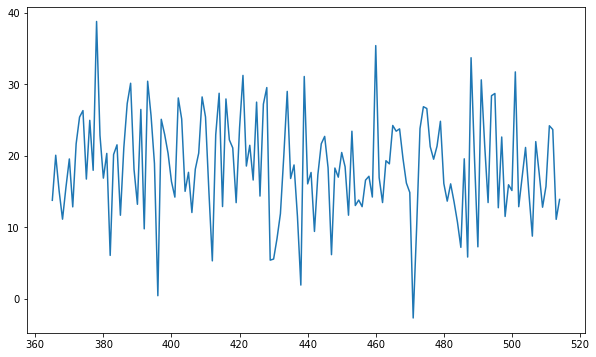

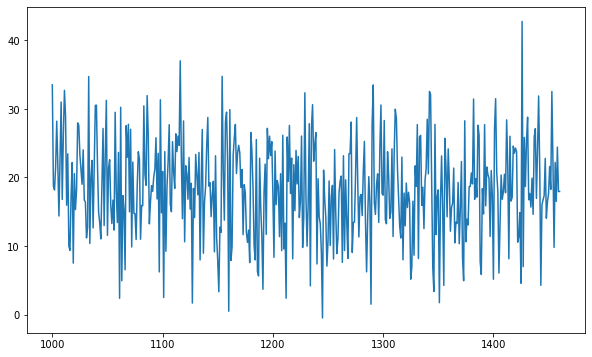

In [71]:
plt.figure(figsize=(10,6))
plot_time_series(diff_time,diff_series,start =0, end=150, label="Series(t) – Series(t–365)")
#########or###########
plt.figure(figsize=(10,6))
plot_time_series(time_valid,diff_series[split_time-365:], label="Series(t) – Series(t–365)")

Great, the trend and seasonality seem to be gone, so now we can use the moving average:

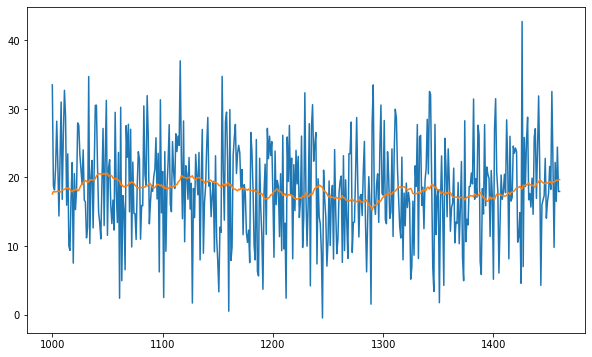

In [81]:
window_size =50
diff_moving_avg = moving_average_forecast(diff_series, window_size=50)[split_time-365 -window_size:]
plt.figure(figsize=(10,6))
plot_time_series(time_valid, diff_series[split_time-365:], label = "Series(t)- Series(t-365)")
plot_time_series(time_valid, diff_moving_avg, label = "Moving Avg of Difference")

Now let's bring back the trend and seasonality by adding the past values from t – 365:

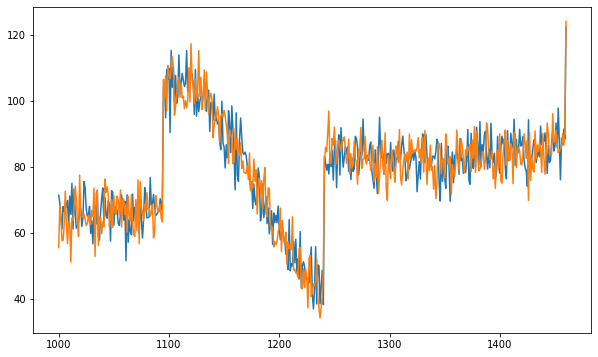

In [88]:
diff_moving_avg_plus_past = series[split_time-365:-365] + diff_moving_avg

plt.figure(figsize=(10,6))
plot_time_series(time_valid, x_valid, label="Series")
plot_time_series(time_valid, diff_moving_avg_plus_past, label = "ForeCast")

In [89]:
error3 = tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past)
error3

<tf.Tensor: shape=(), dtype=float64, numpy=5.8393105629958955>

Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise:

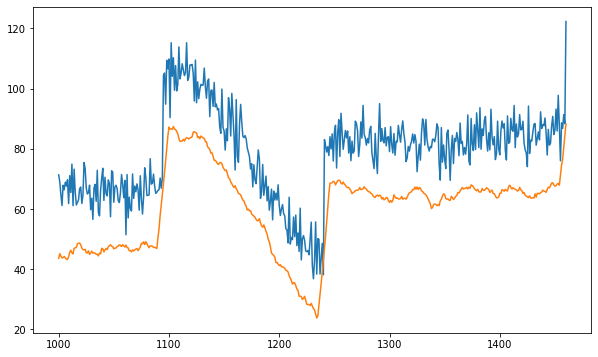

In [96]:
diff_moving_avg_plus_smooth_pase = moving_average_forecast(series[split_time - 370:-359], window_size=11)

plt.figure(figsize=(10,6))
plot_time_series(time_valid, x_valid, label="Series")
plot_time_series(time_valid, diff_moving_avg_plus_smooth_pase, label = "Forecast")